In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import shutil
from tqdm import tqdm
import os
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 59.5 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00


In [7]:
! pip install rembg -q

In [8]:
import zipfile


with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')

In [9]:
data_root = '/kaggle/working/plates/'

In [12]:
from pathlib import Path
from rembg import remove, new_session

In [13]:
session = new_session()

labels = ['cleaned', 'dirty']

for dir_name in ['train', 'val']:
    for l in labels:
        os.makedirs(os.path.join(dir_name, l), exist_ok=True)

for l in labels:
    for i, file in enumerate(tqdm(Path(f"/kaggle/working/plates/train/{l}").glob('*.jpg'))):
        input_path = str(file)
        if i % 5 == 0:
            output_path = f"/kaggle/working/val/{l}/{file.stem}.jpg"
        else:
            output_path = f"/kaggle/working/train/{l}/{file.stem}.jpg"
        with open(input_path, 'rb') as i:
            with open(output_path, 'wb') as o:
                input = i.read()
                output = remove(input, session=session)
                o.write(output)

20it [00:13,  1.52it/s]
20it [00:12,  1.63it/s]


In [14]:
os.makedirs("test/unknown", exist_ok=True)

session = new_session()

for i, file in enumerate(tqdm(Path("/kaggle/working/plates/test").glob('*.jpg'))):
        input_path = str(file)
        output_path = f"/kaggle/working/test/unknown/{file.stem}.jpg"
        with open(input_path, 'rb') as i:
            with open(output_path, 'wb') as o:
                input = i.read()
                output = remove(input, session=session)
                o.write(output)

744it [08:04,  1.53it/s]


In [15]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator


train_datagen=ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True
        )

train_ds = train_datagen.flow_from_directory(
        "./train",
        target_size=(224, 224),
        keep_aspect_ratio=True,
        batch_size=24,
        class_mode='binary',
        shuffle=True)

val_datagen = ImageDataGenerator()

val_ds = val_datagen.flow_from_directory(
        "./val",
        target_size=(224, 224),
        keep_aspect_ratio=True,
        batch_size=8,
        class_mode='binary',
        shuffle=False)

2024-11-25 15:34:41.938415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 15:34:41.938534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 15:34:42.076317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [16]:
import matplotlib.pyplot as plt


def get_image_and_label_batch(dataset, n, labels=None):
    plt.figure(figsize=(3 * min(n, 8), 4 * (n // 8 + 1)))
    if labels is None:
        images, labels = next(dataset)
    else:
        images, _ = next(dataset)
    for i, (img, l) in enumerate(zip(images[:n], labels[:n])):
        ax = plt.subplot(n // 8 + 1, min(n, 8), i + 1)
        plt.imshow(img.astype('uint8'))
        plt.title(l)
        plt.axis("off")

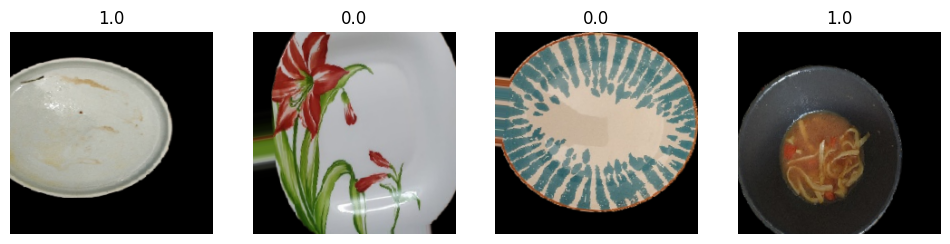

In [ ]:
get_image_and_label_batch(train_ds, 4)

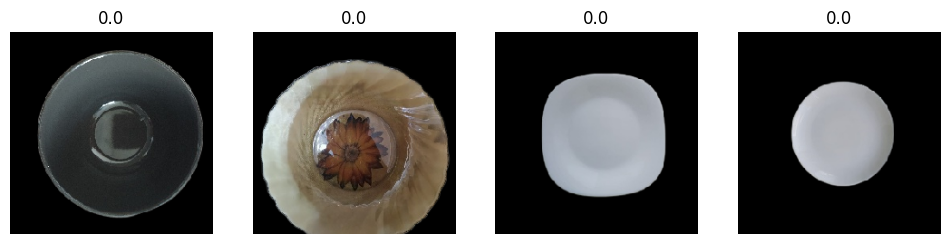

In [18]:
get_image_and_label_batch(val_ds, 4)

In [19]:
import keras


base_model = keras.applications.ResNet152(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,  # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# specific ResNet preprocessing
x = keras.applications.resnet.preprocess_input(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(400, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', 
              optimizer = keras.optimizers.Adam(learning_rate=0.0003, amsgrad=True), 
              metrics=['binary_accuracy'])

model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152           │ (None, 7, 7,      │ 58,370,944 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet152[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 400)       │    819,600 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 400)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        401 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,190,945 (225.80 MB)

 Trainable params: 820,001 (3.13 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [20]:
from tensorflow.python.keras.callbacks import EarlyStopping

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 7)

hist = model.fit(train_ds,
          validation_data=val_ds,
          epochs=200,
          callbacks=[cb_early_stopper])

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/2 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - binary_accuracy: 0.3750 - loss: 1.1243

I0000 00:00:1732548935.468096     162 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1732548935.564851     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - binary_accuracy: 0.4375 - loss: 0.9596 

W0000 00:00:1732548948.529578     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 22s/step - binary_accuracy: 0.4583 - loss: 0.9048 - val_binary_accuracy: 0.3750 - val_loss: 1.0237
Epoch 2/200


W0000 00:00:1732548957.942359     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - binary_accuracy: 0.6250 - loss: 0.5988 - val_binary_accuracy: 0.6250 - val_loss: 0.7402
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - binary_accuracy: 0.8750 - loss: 0.3392 - val_binary_accuracy: 0.8750 - val_loss: 0.6376
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - binary_accuracy: 0.7153 - loss: 0.4304 - val_binary_accuracy: 0.8750 - val_loss: 0.7861
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - binary_accuracy: 0.8125 - loss: 0.3510 - val_binary_accuracy: 0.8750 - val_loss: 0.7467
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - binary_accuracy: 0.9653 - loss: 0.1476 - val_binary_accuracy: 0.8750 - val_loss: 0.6463
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - binary_accuracy: 0.9306 - loss: 0.1367 - val_binary_accuracy: 0.8750 - val_loss: 0.6066
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - binary_accuracy: 0.9167 - loss: 0.1954 - val_binary_accuracy: 0.8750 - val_loss: 0.6142
Epoch 9/200
2/2 ━━━━━━━━━

<Axes: >

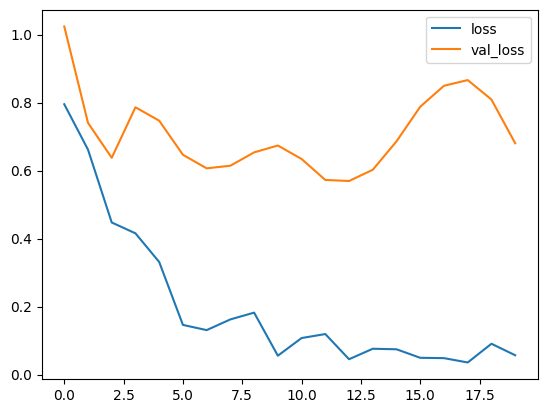

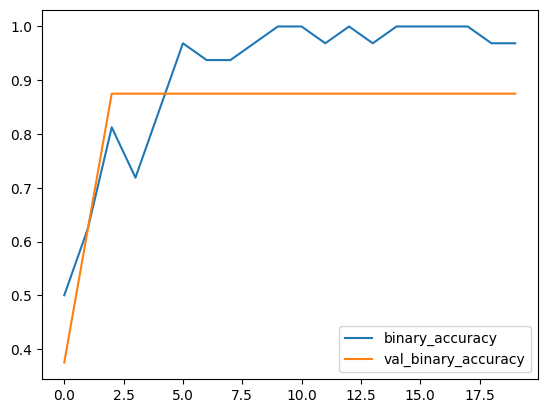

In [21]:
history_frame = pd.DataFrame(hist.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [22]:
shutil.copytree('plates/test', 'test/unknown', dirs_exist_ok=True)

'test/unknown'

In [23]:
test_datagen = ImageDataGenerator()
test_ds = test_datagen.flow_from_directory(
        './test',
        target_size=(224, 224),
        keep_aspect_ratio=True,
        batch_size=32,
        shuffle=False)

Found 744 images belonging to 1 classes.


In [24]:
test_ds.reset()
preds = model.predict(test_ds, verbose=True)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/24 ━━━━━━━━━━━━━━━━━━━━ 5:59 16s/step

W0000 00:00:1732548987.744554     162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 574ms/step


W0000 00:00:1732549000.947820     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [25]:
preds[:10]

array([[0.98965585],
       [0.7265459 ],
       [0.88959605],
       [0.99193025],
       [0.7939819 ],
       [0.9994081 ],
       [0.96904176],
       [0.9649563 ],
       [0.96687627],
       [0.9083729 ]], dtype=float32)

In [ ]:
test_ds.reset()
get_image_and_label_batch(test_ds, 4, labels=preds)

In [27]:
labels = ['dirty' if x > 0.5 else 'cleaned' for x in preds]
labels[:8]

['dirty', 'dirty', 'dirty', 'dirty', 'dirty', 'dirty', 'dirty', 'dirty']

In [28]:
submission_df = pd.read_csv('/kaggle/input/platesv2/sample_submission.csv')

In [29]:
submission_df['label'] = labels

In [30]:
submission_df

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty
...,...,...
739,739,dirty
740,740,dirty
741,741,cleaned
742,742,dirty


In [31]:
submission_df.to_csv('submission.csv', index=False)

In [32]:
!rm -rf train val test plates